In [1]:
import numpy as np
import matplotlib.pyplot as plt
import asdf
from matplotlib import rc
from scipy.optimize import curve_fit
import symlib
import sys
sys.path.append('/sdf/home/j/jaymarie/software/gravitree/python')
import gravitree
from scipy.integrate import quad
import astropy.constants as cons
import astropy.units as u
from tqdm import tqdm
from glob import glob

from plot import setFonts
setFonts()

from gala.potential import PlummerPotential
from gala.dynamics import PhaseSpacePosition

from gala.units import galactic

sim_dir = "/fs/ddn/sdf/group/kipac/g/cosmo/ki21/phil1/simulations/ZoomIns/SymphonyMilkyWay/Halo023"

from mwgcs import Simulation, GCSystem, MassProfile, tidalRadius, getMassLossRate, getTidalTimescale, getTidalFrequency, getLambda, NFW

sim = Simulation(sim_dir)

Gravitree path added to sys.path.


# plummer

In [2]:
def analyticPotential(r, m, a):
    return -cons.G * m / (r**2 + a**2)**(1/2)

def analyticPotential_r(r, m, a):
    return cons.G * m * r / (r**2 + a**2)**(3/2)

def analyticPotential_rr(m, r, a):
    phi_rr = - (cons.G * m * ((2 * (r**2.)) - (a**2.))) / (r**2 + a**2)**(5/2)
    return phi_rr.to(u.Gyr**(-2))

def analyticLambdaBaryon(m, r, a):
    phi_rr = - (cons.G * m * ((2 * (r**2.)) - (a**2.))) / (r**2 + a**2)**(5/2)
    return np.abs(phi_rr * (2/3)).to(u.Gyr**(-2))

In [3]:
r_exp = 3 * u.kpc
r_half = np.log(2) * r_exp
a = (r_half / (1.3)).value
m0 = 4e10

In [4]:
pot = PlummerPotential(m0 * u.Msun, a * u.kpc, units=galactic) 

r = np.logspace(-1, 3, 1000)
lams = []
for r_i in r:
    H_ij = pot.hessian([r_i, 0, 0])
    tensor = (-(1/3)*np.trace(H_ij) * np.identity(3) + H_ij)
    lam = (np.max(np.abs(np.linalg.eig(tensor)[0]))).to(1/u.Gyr**2).value
    # lam = np.abs(2*H_ij[0,0]/3).to(1/u.Gyr**2).value
    lams.append(lam)

In [5]:
lams_b_analytic = analyticLambdaBaryon(m0 * u.Msun, r * u.kpc, a * u.kpc)

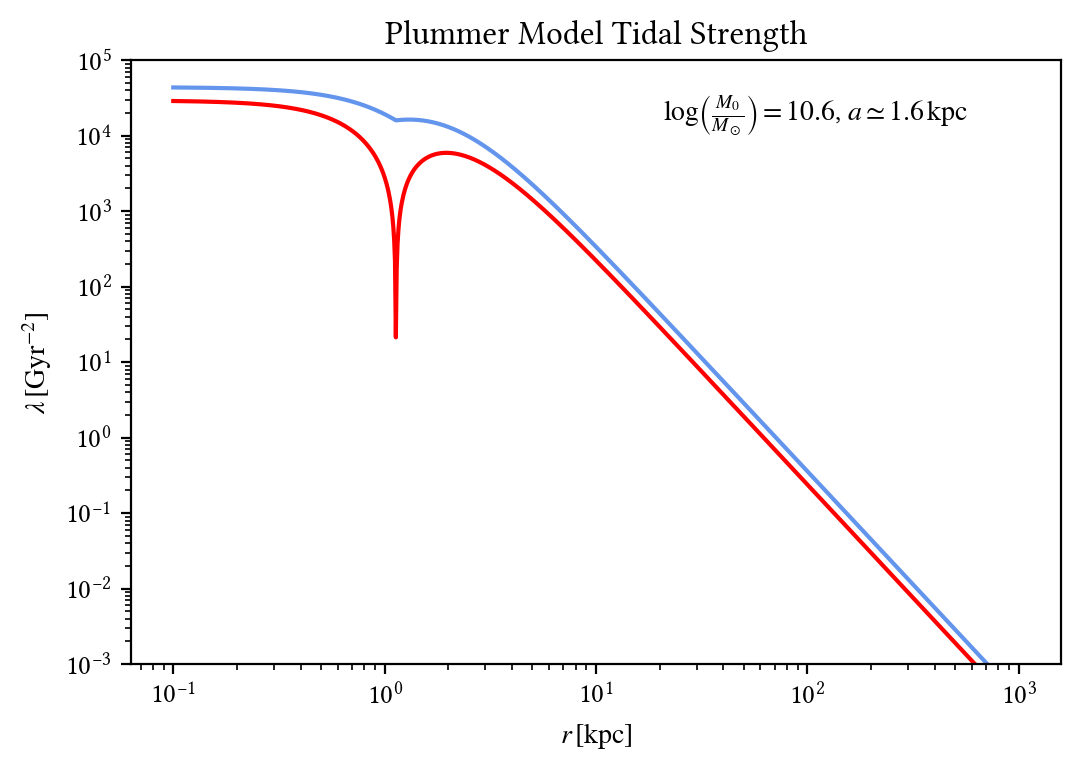

In [6]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, lams, c='cornflowerblue')
ax.loglog(r, lams_b_analytic, c='red')
ax.set_title(r'Plummer Model Tidal Strength')
ax.text(.9, .9, r'$\log\left(\frac{M_0}{M_\odot}\right) = 10.6$, $a \simeq 1.6 \mathrm{\, kpc}$', transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$\lambda\, \mathrm{[Gyr^{-2}]}$')
ax.set_xlabel(r'$r \, \mathrm{[kpc]}$')
ax.set_ylim(1e-3, 1e5)
plt.show()

In [7]:
gala_vc = pot.circular_velocity(np.array([r * u.kpc, np.zeros_like(r), np.zeros_like(r)]))
analytic_vc = np.sqrt(r * u.kpc * analyticPotential_r(r * u.kpc, m0 * u.Msun, a * u.kpc)).to(u.km/u.s)

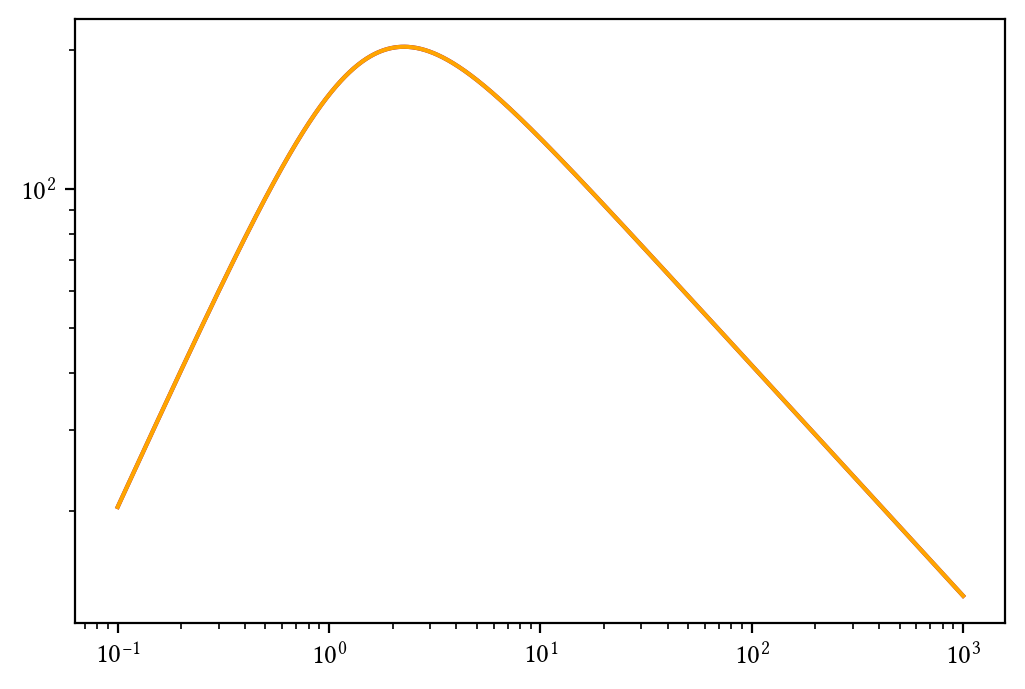

In [8]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, gala_vc, c='purple', label='gala')
ax.loglog(r, analytic_vc, c='orange', label='homemade')
plt.show()

In [9]:
homemade_rr = analyticPotential_rr(m0 * u.Msun, r * u.kpc, a * u.kpc).to(u.Gyr**(-2))
gala_rr = pot.hessian(np.array([r * u.kpc, np.zeros_like(r), np.zeros_like(r)]))[0, 0].to(u.Gyr**(-2))

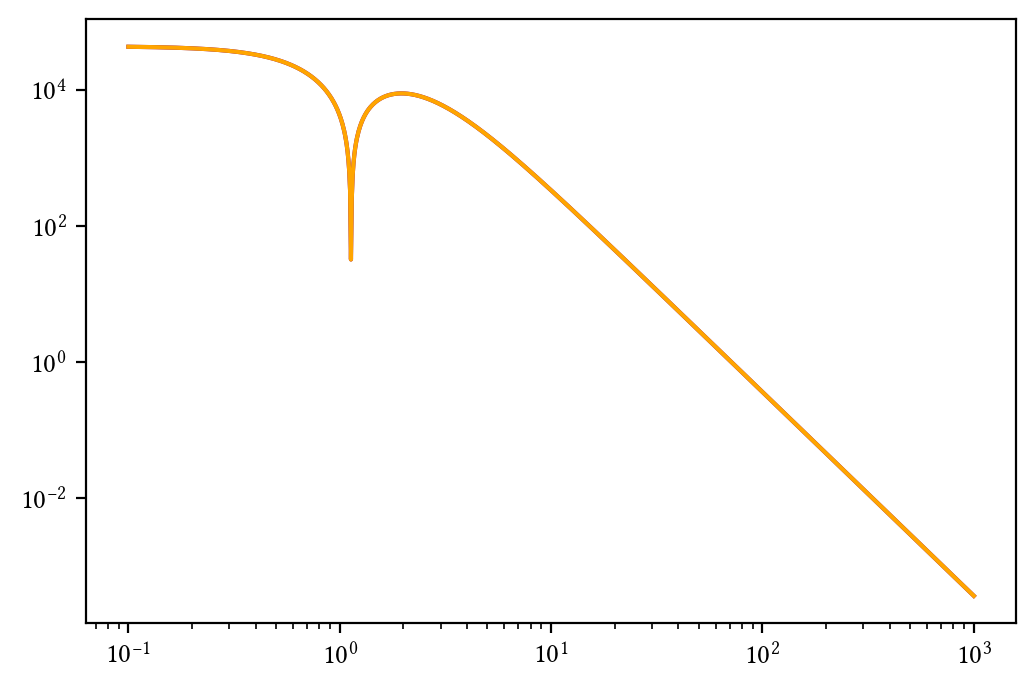

In [10]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, np.abs(gala_rr), c='purple', label='gala')
ax.loglog(r, np.abs(homemade_rr), c='orange', label='homemade')
plt.show()

In [11]:
# double check if this is correct
# plot that analytic form of the hessian

# composite

In [12]:
profile = MassProfile(sim, 235, 0)
m = 2e5
_ = profile.fit()
r_t_mw = np.array([tidalRadius(R_i, m, profile) for R_i in r], dtype=object) * u.kpc
lams_dm = (cons.G * m * u.Msun / (r_t_mw)**3).to(u.Gyr**(-2))

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


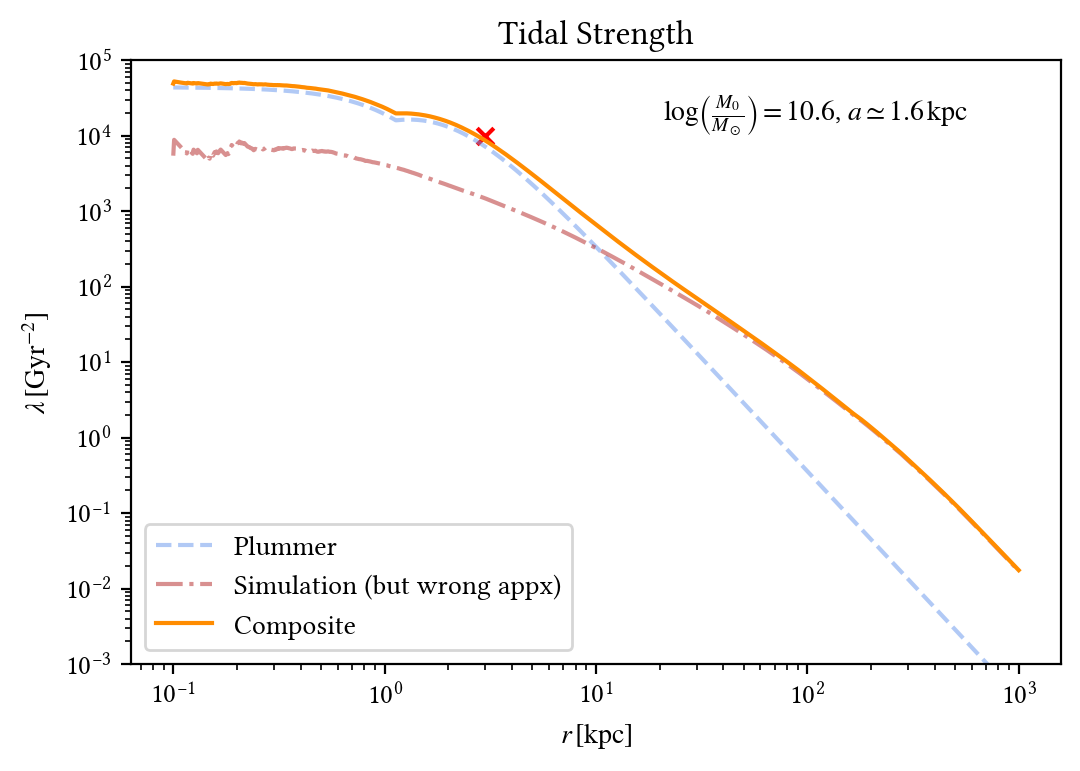

In [13]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, lams, c='cornflowerblue', ls='--', alpha=.5, label='Plummer')
ax.loglog(r, lams_dm, c='firebrick', ls='-.', alpha=.5, label='Simulation (but wrong appx)')
ax.loglog(r, lams+lams_dm.value, c='darkorange', label='Composite')

ax.scatter(3., 1e4, marker='x', c='r')

ax.set_title(r'Tidal Strength')
ax.text(.9, .9, r'$\log\left(\frac{M_0}{M_\odot}\right) = 10.6$, $a \simeq 1.6 \mathrm{\, kpc}$', transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$\lambda\, \mathrm{[Gyr^{-2}]}$')
ax.set_xlabel(r'$r \, \mathrm{[kpc]}$')
ax.set_ylim(1e-3, 1e5)
ax.legend(loc='lower left')
plt.show()

In [14]:
gc = GCSystem(sim, 2)

/sdf/home/j/jaymarie/mwgcs/mwgcs/form.py:15: RuntimeWarning: invalid value encountered in log10
  mgc = 1/(1 + np.exp(-(b0 + (b1 * np.log10(ms))))) * (g0 + (g1*np.log10(ms)))
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [15]:
gc.evolve(0)

0it [00:02, ?it/s]


AttributeError: 'NoneType' object has no attribute 'analyticSlope'

In [ ]:
gc.profile.fit()

In [ ]:
gc.profile._ein.analyticSlope